## Filtrado de la señal ECG utilizando filtros IIR, FIR y wavelet

#### Importación de librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import signal

c:\Users\FRANCISCO\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Abrir archivo txt

In [3]:
f = open("signals/ECG_reposo_sujeto2.txt")
raw_data = f.readlines()[1] # con f.read() leemos todo el contenido
f.close()

raw_data

'# {"98:D3:71:FD:62:1E": {"position": 0, "device": "bitalino_rev", "device name": "98:D3:71:FD:62:1E", "device connection": "BTH98:D3:71:FD:62:1E", "sampling rate": 1000, "resolution": [4, 1, 1, 1, 1, 10], "firmware version": 1282, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2023-9-15", "time": "10:30:59.552", "channels": [2], "sensor": ["ECGBIT"], "label": ["A2"], "column": ["nSeq", "I1", "I2", "O1", "O2", "A2"], "special": [{}], "digital IO": [0, 0, 1, 1]}}\n'

In [4]:
x = re.findall("[0-5][0-9][0-9]\d", raw_data)

print(x)

['1000', '1282', '2023']


In [5]:
Fs = float(x[0])
Ts=1/Fs

print(f" Fs={Fs} hz\n Ts={Ts} s")

 Fs=1000.0 hz
 Ts=0.001 s


#### Lectura de archivos excluyendo encabezados

In [6]:
SenalECG = np.genfromtxt("Signals/ECG_reposo_sujeto2.txt", delimiter="\t",skip_header = 3)


#### Visualización de la señal cruda

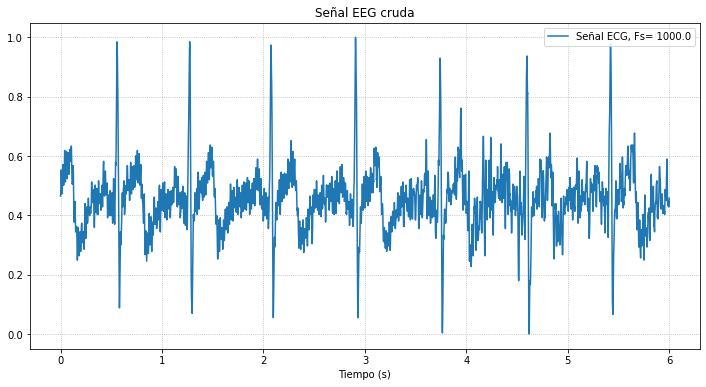

In [7]:
# Conversión de las señales en arrays
ECG = SenalECG[:,5]
ECG = ECG [:6000]

#Normalización
y1 = ECG  - np.min(ECG)
y1 = y1 / np.max(y1)
t1 = (np.arange(0,len(y1)) / Fs)

plt.figure(figsize=(12,6))
plt.plot(t1, y1, label=f"Señal ECG, Fs= {Fs}")
plt.legend(loc="upper right")
plt.title("Señal EEG cruda")    # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ECG_crudo.png', transparent=False, )



#### Aplicación de filtros

##### Filtro IIR

In [9]:
Wp = 1/ (Fs/2)
Ws = 50/(Fs/2)

N_ord, Wc= signal.buttord(Wp, Ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies 

print(f"Orden del filtro: {N_ord}")


Orden del filtro: 2


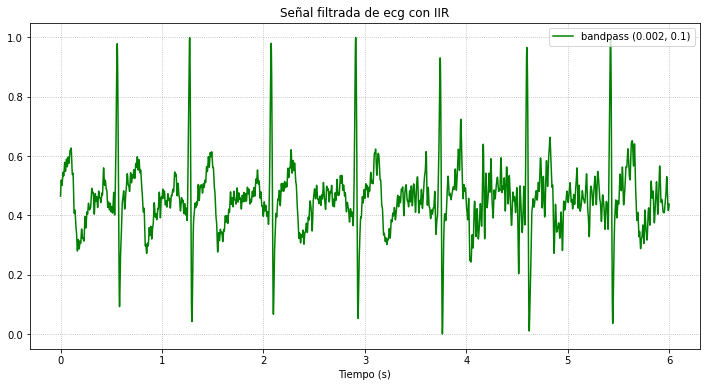

In [10]:
b, a = signal.butter(N_ord,[Wp,Ws],'bandpass')
ecg_filtered= signal.filtfilt(b, a, y1)
ecg_filtered = ecg_filtered  - np.min(ecg_filtered)
ecg_filtered = ecg_filtered / np.max(ecg_filtered)

#Visualizacion
plt.figure(figsize=(12,6))
plt.title('Señal filtrada de ecg con IIR')
plt.plot(t1,ecg_filtered, color ="green", label=f"bandpass {Wp, Ws}")
plt.legend(loc="upper right")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ECG_FiltroIIR.png', transparent=False, )

##### Aplicacion de filtro FIR

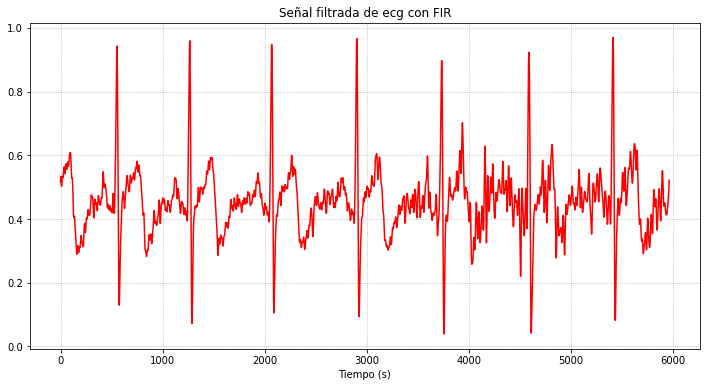

In [11]:
from scipy.signal import firwin, lfilter


M = 56 # Orden del fitro
Fc = 50 # Frecuencia alta

#Diseño del filtro
w = signal.firwin(numtaps=M, cutoff=Fc, window='hamming', fs=Fs)
w = np.round(w,3)

#Aplicación del filtro
ecg_filtered_fir = signal.lfilter(w,np.array(1),y1)

#Visualizacion
plt.figure(figsize=(12,6))
plt.title('Señal filtrada de ecg con FIR')
plt.plot(ecg_filtered_fir[34:], color="red")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ECG_FiltroFIR.png', transparent=False, )



##### Aplicacion del filtro utilizando Wavelet

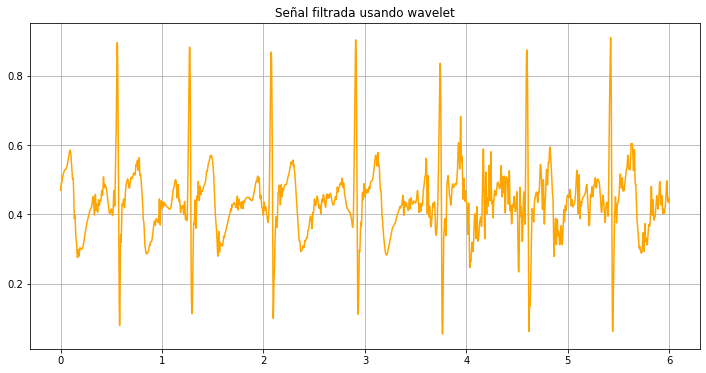

In [12]:
import pywt

coeffs = pywt.wavedec(y1, 'db6', level=5)
umbral = 0.1

# Aplicar el umbral a los coeficientes
coeffs_umbral = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]

# Reconstruir la señal denoised
senal_denoised = pywt.waverec(coeffs_umbral, 'db6')
#Visualizacion

plt.figure(figsize=(12,6))
plt.title('Señal filtrada usando wavelet')
plt.plot(t1,senal_denoised, color="orange")
plt.grid()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ECG_Filtrowavelet.png', transparent=False, )

#### Comparación entre los resultados

##### Visualización de los gráficos

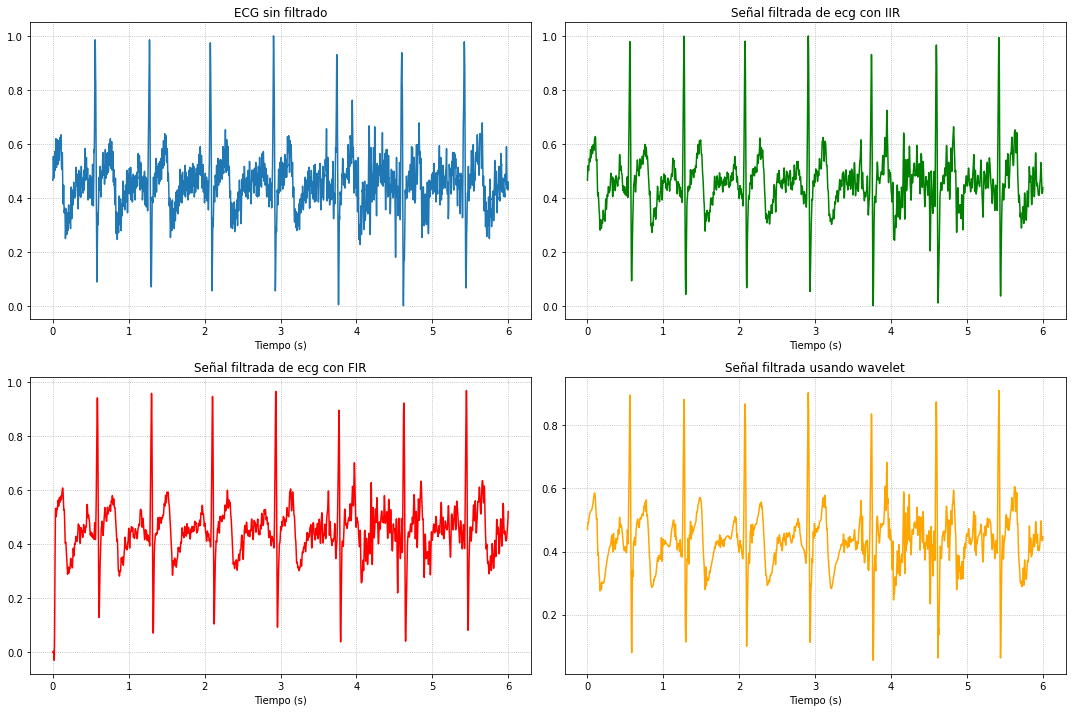

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.subplots_adjust(hspace=0.6,wspace=0.6)

#Ecg crudo
plt.plot(t1, y1)
plt.title("ECG sin filtrado")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")

#ecg filtrado IIR
plt.subplot(2,2,2)
plt.title('Señal filtrada de ecg con IIR')
plt.plot(t1,ecg_filtered, color ="green")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")

#ecg filtrado con FIR
plt.subplot(2,2,3)
plt.title('Señal filtrada de ecg con FIR')
plt.plot(t1,ecg_filtered_fir, color="red")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")

#ecg utilizando wavelets
plt.subplot(2,2,4)
plt.title('Señal filtrada usando wavelet')
plt.plot(t1,senal_denoised, color="orange")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ECG_comparison.png', transparent=False, )
plt.tight_layout()
plt.show()

##### Respuesta en frecuencia de las señales filtradas

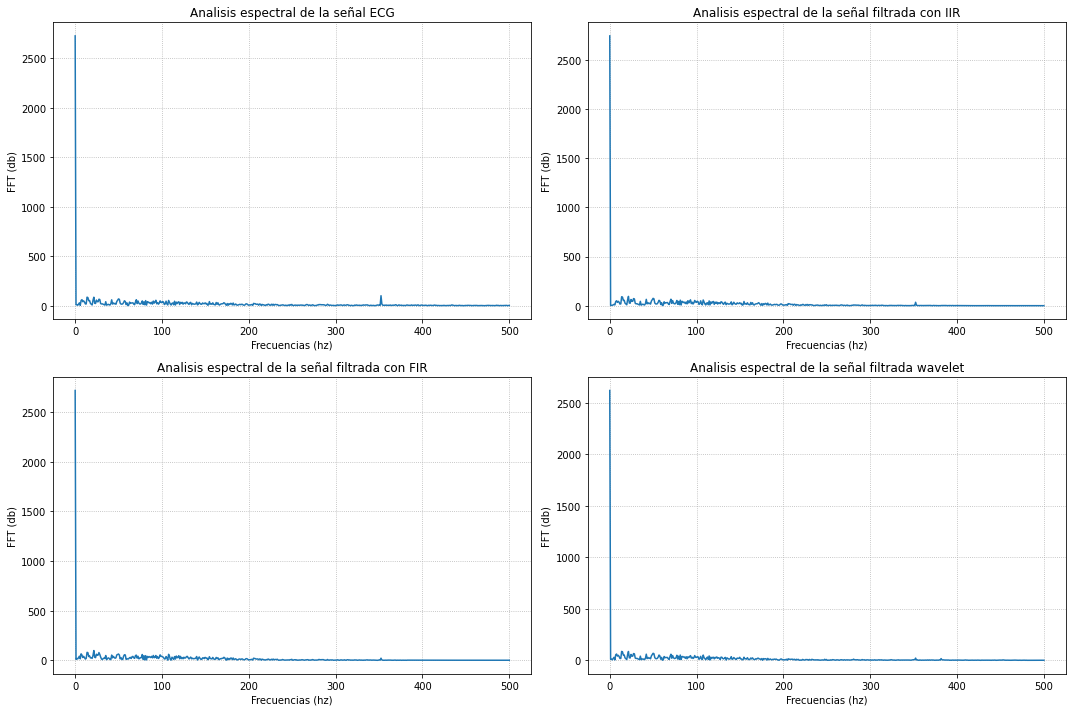

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.subplots_adjust(hspace=0.6,wspace=0.6)

# señal sin procesar
N = 2 ** 10 # Resolución del bitalino
X = np.fft.fft(y1)
X = X[0:N//2]
X = np.abs(X)
F = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,1)
plt.plot(F, X)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal ECG")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")

# Filtrado con IIR
X1 = np.fft.fft(ecg_filtered)
X1 = X1[0:N//2]
X1 = np.abs(X1)
F1 = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,2)
plt.plot(F1, X1)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada con IIR")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")

# filtrado con FIR
X2 = np.fft.fft(ecg_filtered_fir)
X2 = X2[0:N//2]
X2 = np.abs(X2)
F2 = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,3)
plt.plot(F2, X2)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada con FIR")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")

# Filtrado con wavelet
X3 = np.fft.fft(senal_denoised)
X3 = X3[0:N//2]
X3 = np.abs(X3)
F3 = np.linspace(0,Fs/2,N//2)
plt.subplot(2,2,4)
plt.plot(F3, X3)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada wavelet")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('ECG_respuestaenFreq.png', transparent=False, )
plt.tight_layout()
plt.show()